# One-dimensional Facebook

In this notebook we reshape the real data into a form that can be further processed by the neural network. We also dissect the sequence into small segments.

In [1]:
# for model and data input
import pandas as pd
import numpy as np

# for visualization
from include import *

choice_1 = 'real'
choice_2 = 'real log'

## Parameters of data

In [2]:
# dimension of stochastic vector (St,Zt)
para={}
para['DIM_X'] = 2
para['DIM_S'] = 1
para['DIM_Z'] = 1
## make sure that para['SHORT_L'] is an integer
para['L_OF_DAY']=78
para['DROP']=3
para['SHORT_L']=int(para['L_OF_DAY']/para['DROP'])

## Load data

In [3]:
# data input
file_location = "./Original data/FACEBOOK-5min.csv"
data = pd.read_csv(file_location)

data[['A','B']] = data['日期'].str.split(' ',n=1, expand = True)
data[['year','month','day']]=data['A'].str.split('-',n=2,expand = True)
data = data.drop(data.loc[(data['year']== "2020") &(data["month"]=="02")].index)
data = data.drop(data.loc[(data['year']== "2020") &(data["month"]=="03")].index)

data = data.drop(data.loc[data['B']=="20:00"].index)
data['ticks'] = data.groupby("A")["收盘价(元)"].transform('count')
data = data.drop(data.loc[data['ticks']<para['L_OF_DAY']].index)

observes=int((len(data)-2)/para['L_OF_DAY'])

## Process data

In [4]:
# store the dataset as an array with dimensions observes*para['L_OF_DAY']
data_origin=np.empty([observes,para['L_OF_DAY']])
for i in range(observes):
    for j in range(0,para['L_OF_DAY']):
        data_origin[i,j]=data.iloc[int(i*para['L_OF_DAY']+j),6]
        
# drop two datapoints in every 3, so that the sequences are not too long.
data_dropped=np.empty([observes,para['SHORT_L']])
for i in range(observes):
    for j in range(para['SHORT_L']):
        data_dropped[i,j]=data_origin[i,j*3]

# subtract from each sequence the value of the first datapoint, so that the sequences become sequences of return prices that begin with 0
# however, to make sure that the sequences are not to strange, we let them begin with the second datapoint
data_obs=np.empty([observes,para['SHORT_L']-1])
for i in range(0,observes):
    for j in range(para['SHORT_L']-1):
        data_obs[i,j]=data_dropped[i,j+1]-data_dropped[i,0]

## Transform into log return

In [5]:
data_obs_log=np.empty([observes,para['SHORT_L']]) #第一项是logS_0，后面每一项是logS_t-logS_(t-1)
for i in range(observes):
    data_obs_log[i,0]=np.log(data_dropped[i,0]) #数据的第一项是logS_0
    for j in range(para['SHORT_L']-1):
        data_obs_log[i,j+1]=np.log(data_dropped[i,j+1])-np.log(data_dropped[i,j])

### transformation into 3-d array

In [6]:
data_obs = data_obs.reshape((observes,para['SHORT_L']-1,1))
data_obs_log = data_obs_log.reshape((observes,para['SHORT_L'],1))

## Visualization

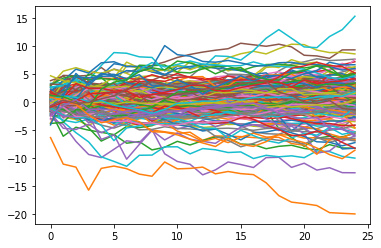

In [7]:
visualize(choice_1, data_obs)

## Visualization of log return

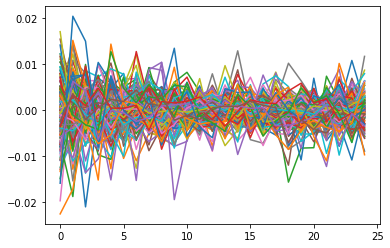

In [8]:
visualize(choice_2, data_obs_log)

## Save processed data

In [9]:
np.save('./Processed and simulated data/data_obs_'+choice_1+'.npy',data_obs)
np.save('./Processed and simulated data/data_obs_'+choice_2+'.npy',data_obs_log)